In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 


3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# gdf = gpd.read_file("../data/iris/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("../data/iris/gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("../data/iris/gdf.pickle", "rb") as f:
    gdf_france = pickle.load(f)
    geojson=gdf_france.__geo_interface__
    len(gdf_france)

In [3]:
years = list(range(20,26))
spe_df = pd.read_sql("select id, label, label_long from specialite", config.connection_string, index_col="id")
spe_df.T

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
label,Psychiatre,Anest,Dermato,Gastro,Gyneco,Opthtalmo,Pediatre,Radio,Dentiste,Generaliste,Cardio,Chirugien,Endocrino,Geriatre,Neuro,ORL,Pneumo,Radiotherapeuthe,Rhumato,Stomato
label_long,Psychiatre,Anesthésiste,Dermatologue,Gastro-entérologue,Gynécologue,Opthtalmogue,Pédiatre,Radiologue,Dentiste,Généraliste,Cardiologue,Chirugien,Endocrinologue,Gériatre,Neurologue,Oto-rhino-laryngologiste,Pneumologue,Radiothérapeuthe,Rhumatologue,Stomatologue


Documentation

code_commune: il y a plusieurs possibilités :
* le code de la commune sur 5 chiffres, par exemple "06088" pour Nice
* certains anciens code commune sont accepté comme 75101 pour Paris 1er arrondissement
* le département sur 2 chiffres, par exemple "06"
* le code IRIS sur 9 chiffres, par exemple "382050000"
* une liste de code IRIS entre crochet, par exemple \["385480000", "382050000"]
* le code IRIS avec un joker de type "3820%"
* pour la corse utiliser les préfixes 2A ou 2B et non 20, par exemple "2A004"

specialite: voir tableau ci dessus

year: l'année sur 2 chiffre en 20 et 25

source: "PA" pour ps_libreacces ou "PS"

time: 30 ou 45, il est possible d'en faire d'autre mais il faut lancer les calculs

time_type: "HC" ou "HP"

Puis appuer 7 fois sur le bouton Run this cell (bouton play) ou 1 fois sur le bouton Restart (bouton avec double flèche à droite FFW)

L'échelle de couleur est normalisée par rapport aux quantiles de la france entière affichés un peu plus bas

In [237]:
code_commune = "38185" #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "38548" "2A004" "382050000" ["385480000", "382050000"] "45" "14581" bug
specialite = 10
year = 25 # 20 to 25
source="PA" # PA or PS
time=30 # 30 or 45
time_type="HC" # HC or HP

# TODO faire slider dans un autre notebook

if type(code_commune) is list:
    type_code = "LIST"
elif "%" in code_commune and len(code_commune) > 2:
    type_code = "LIKE"
elif len(code_commune) == 2:
    type_code = "LIKE"
    code_commune = code_commune + "%"
elif len(code_commune) == 5:
    type_code = "COM"
elif len(code_commune) == 9:
    type_code = "IRIS"
else:
    raise ValueError(f"Bad {code_commune}")
print(f"Type code: {type_code}")

Type code: COM


In [238]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
commune_nom = None
if type_code=="COM":
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
elif type_code in ["IRIS", "LIKE"]:
    iriss = [code_commune]
elif type_code == "LIST":
    iriss = code_commune
print(f"Found {len(iriss)} iris for {commune_nom}")

if type_code == "LIKE":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(code_commune[:-1])]
elif len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"
if commune_nom is None:
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)

Found 70 iris for Grenoble
Found 70 geo iris for Grenoble, type_code: COM


,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
38,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669
3489,IRIS____0000000381850102,38185,Grenoble,0102,381850102,Jean Macé,H,"MULTIPOLYGON (((5.68498 45.21175, 5.68849 45.2...",3489,5.707723,45.202059


In [239]:
def get_study_by_year(year):
    sql = f"""
    select * from apl.apl_study s
    where s.specialite_id={specialite}
    and s.year={year}
    and s.source='{source}'
    and s.time={time}
    and s.time_type='{time_type}'
    order by date desc
    limit 1
    """
    return pd.read_sql(sql, config.connection_string)

def get_studies_by_years(years: list[int]):
    df = None
    for year in years:
        if df is None:
            df = get_study_by_year(year)
        else:
            df = pd.concat([df, get_study_by_year(year)], ignore_index=True)
    return df
        
        
    
study_df = get_study_by_year(year)
study_df
studies_df = get_studies_by_years(years)
studies_df

,year,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key
0,20,10,PA,30,HC,-0.12,69.297407,37.799369,31.187375,42.506375,59.518193,88.822859,123.141263,0.0,729.717071,2025-11-03 17:59:14.135431,631398255889
1,21,10,PA,30,HC,-0.12,68.111090,37.277252,30.308121,41.535432,58.462969,87.538606,121.209476,0.0,698.242979,2025-11-03 18:30:06.142709,29314072625
2,22,10,PA,30,HC,-0.12,67.071004,37.121242,29.442089,40.697967,57.480673,86.097910,119.758972,0.0,697.801416,2025-11-03 19:00:49.629990,897661281410
3,23,10,PA,30,HC,-0.12,67.704332,37.705785,29.435266,40.971273,57.986870,86.747319,121.704998,0.0,671.098376,2025-11-03 19:31:43.410384,418240373987
4,24,10,PA,30,HC,-0.12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2025-11-03 20:01:11.977184,223703770518
5,25,10,PA,30,HC,-0.12,67.986720,39.066083,28.615094,40.271740,57.626053,87.523240,123.805566,0.0,697.067620,2025-11-03 20:30:55.114133,408893757334


In [240]:
key = study_df["key"].iloc[0]
keys = studies_df["key"].values
print(f"Studies keys: {keys}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and code_commune='{code_commune}'
    """
elif type_code == "IRIS":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string='{code_commune}'
    """
elif type_code == "LIKE":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string like '{code_commune}'
    """
elif type_code == "LIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string in {tuple(code_commune)}
    """
print(sql)
apl = pd.read_sql(text(sql), config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    """
    apl = pd.read_sql(sql, config.connection_string)
apl

Studies keys: [631398255889  29314072625 897661281410 418240373987 223703770518
 408893757334]

    select * from apl.apl a
    where a.study_key in (631398255889, 29314072625, 897661281410, 418240373987, 223703770518, 408893757334)
    and code_commune='38185'
    


,year,specialite,iris,iris_string,type_iris,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key
0,21,10,381850101,381850101,C,0.000000,136.807613,0.000000,1.0,0.000000,33.277469,142829.043143,33.277469,40.000053,Polygone,38,38185,Grenoble,29314072625
1,21,10,381850102,381850102,A,1.000000,133.355697,0.682547,1.0,0.682547,3784.801143,146510.013025,3784.801143,4684.638460,Jean Macé,38,38185,Grenoble,29314072625
2,21,10,381850103,381850103,A,1.500000,141.785117,0.953041,1.0,0.953041,2023.443364,157390.960411,2023.443364,2590.538105,Europole,38,38185,Grenoble,29314072625
3,21,10,381850104,381850104,A,3.000000,155.089149,1.753005,1.0,1.753005,2084.757916,171134.670950,2084.757916,2385.592180,Diderot,38,38185,Grenoble,29314072625
4,21,10,381850105,381850105,A,1.000000,165.505616,0.551063,1.0,0.551063,1550.863246,181467.539589,1550.863246,1757.837155,Gare,38,38185,Grenoble,29314072625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,22,10,381850607,381850607,A,0.000000,134.544007,0.000000,1.0,0.000000,1430.029731,165701.113238,1430.029731,1672.736037,Baladins,38,38185,Grenoble,897661281410
416,22,10,381850608,381850608,A,0.000000,148.523144,0.000000,1.0,0.000000,5067.289924,183240.465296,5067.289924,5854.680322,Vigny-Musset,38,38185,Grenoble,897661281410
417,22,10,381850609,381850609,A,2.000000,142.888096,1.133617,1.0,1.133617,1486.538872,176426.436401,1486.538872,1720.047629,Village Olympique Nord,38,38185,Grenoble,897661281410
418,22,10,381850610,381850610,A,0.000000,142.218389,0.000000,1.0,0.000000,1377.812387,177095.998357,1377.812387,1624.084717,Village Olympique Sud,38,38185,Grenoble,897661281410


In [241]:
# Bug apl year temporary correction (fixed in apl_france.py)
# update apl.apl as a
# set year=s.year
# from apl.apl_study as s
# where s.key=a.study_key
# and a.year!=s.year --43min

if len(apl[apl["iris_string"]=="180331201"])>0 and len(apl[apl["iris_string"]=="181740000"])>0:
    apl.loc[apl["iris_string"]=="180331201","apl"]=apl[apl["iris_string"]=="181740000"]["apl"].iloc[0]
if len(apl[apl["iris_string"]=="140110000"])>0:
    apl.loc[apl["iris_string"]=="140110000","iris_string"]="145810000"

In [242]:
apl["code_iris"]=apl["iris_string"]
gdf_merged = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
gdf_merged["pretty"]=gdf_merged["apl"].fillna(0).apply(lambda x: round(x, 0)).astype(np.int32)
gdf_merged["pop_ajustee"]=gdf_merged['pop_gp']
gdf_merged

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,year,specialite,iris_dest,iris_string,type_iris_dest,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,pretty,pop_ajustee
0,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,21,10,381850101,381850101,C,0.000000,136.807613,0.000000,1.0,0.000000,33.277469,142829.043143,33.277469,40.000053,Polygone,38,38185,Grenoble,29314072625,137,33.277469
1,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,24,10,381850101,381850101,C,0.000000,0.000000,0.000000,1.0,0.000000,33.437654,142942.766910,33.437654,40.000053,Polygone,38,38185,Grenoble,223703770518,0,33.437654
2,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,25,10,381850101,381850101,C,0.000000,138.310850,0.000000,1.0,0.000000,33.437654,142942.766910,33.437654,40.000053,Polygone,38,38185,Grenoble,408893757334,138,33.437654
3,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,23,10,381850101,381850101,C,0.000000,136.039465,0.000000,1.0,0.000000,33.288452,142855.788945,33.288452,40.000053,Polygone,38,38185,Grenoble,418240373987,136,33.288452
4,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,20,10,381850101,381850101,C,0.000000,139.437678,0.000000,1.0,0.000000,32.872008,142579.908398,32.872008,40.000070,Polygone,38,38185,Grenoble,631398255889,139,32.872008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,24,10,381850611,381850611,C,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,183585.842339,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,223703770518,0,0.000000
416,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,25,10,381850611,381850611,C,0.333333,156.710926,0.181568,1.0,0.181568,0.000000,183585.842339,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,408893757334,157,0.000000
417,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,23,10,381850611,381850611,C,0.500000,157.061474,0.272507,1.0,0.272507,0.000000,183481.268504,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,418240373987,157,0.000000
418,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,20,10,381850611,381850611,C,0.333333,158.707205,0.181380,1.0,0.181380,0.000000,183776.149747,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,631398255889,159,0.000000


In [243]:
qmaxs = []
q90s = []
q75s = []
q50s = []
q25s = []
q10s = []
gdf_merged["apl_clip"]=gdf_merged["apl"]
for year in years:
    qmaxs.append(studies_df[studies_df["year"]==year]["max"].iloc[0] if studies_df[studies_df["year"]==year]["max"].iloc[0] != 0 else 1.0)
    q90=studies_df[studies_df["year"]==year]["q90"].iloc[0] if studies_df[studies_df["year"]==year]["q90"].iloc[0] != 0 else 1.0
    q90s.append(q90)
    q75=studies_df[studies_df["year"]==year]["q75"].iloc[0] if studies_df[studies_df["year"]==year]["q75"].iloc[0] != 0 else 0.0
    q75s.append(q75)
    q50=studies_df[studies_df["year"]==year]["q50"].iloc[0] if studies_df[studies_df["year"]==year]["q50"].iloc[0] != 0 else q75
    q50s.append(q50)
    q25=studies_df[studies_df["year"]==year]["q25"].iloc[0] if studies_df[studies_df["year"]==year]["q25"].iloc[0] != 0 else q50
    q25s.append(q25)
    q10s.append(studies_df[studies_df["year"]==year]["q10"].iloc[0] if studies_df[studies_df["year"]==year]["q10"].iloc[0] != 0 else q25)
    gdf_merged.loc[gdf_merged["year"]==year,"apl_clip"]=gdf_merged[gdf_merged["year"]==year]["apl"].clip(0,q90)
q50s
gdf_merged

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,year,specialite,iris_dest,iris_string,type_iris_dest,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,pretty,pop_ajustee,apl_clip
0,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,21,10,381850101,381850101,C,0.000000,136.807613,0.000000,1.0,0.000000,33.277469,142829.043143,33.277469,40.000053,Polygone,38,38185,Grenoble,29314072625,137,33.277469,121.209476
1,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,24,10,381850101,381850101,C,0.000000,0.000000,0.000000,1.0,0.000000,33.437654,142942.766910,33.437654,40.000053,Polygone,38,38185,Grenoble,223703770518,0,33.437654,0.000000
2,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,25,10,381850101,381850101,C,0.000000,138.310850,0.000000,1.0,0.000000,33.437654,142942.766910,33.437654,40.000053,Polygone,38,38185,Grenoble,408893757334,138,33.437654,123.805566
3,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,23,10,381850101,381850101,C,0.000000,136.039465,0.000000,1.0,0.000000,33.288452,142855.788945,33.288452,40.000053,Polygone,38,38185,Grenoble,418240373987,136,33.288452,121.704998
4,IRIS____0000000381850101,38185,Grenoble,0101,381850101,Polygone,A,"MULTIPOLYGON (((5.70173 45.19243, 5.70173 45.1...",38,5.697205,45.202669,20,10,381850101,381850101,C,0.000000,139.437678,0.000000,1.0,0.000000,32.872008,142579.908398,32.872008,40.000070,Polygone,38,38185,Grenoble,631398255889,139,32.872008,123.141263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,24,10,381850611,381850611,C,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,183585.842339,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,223703770518,0,0.000000,0.000000
416,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,25,10,381850611,381850611,C,0.333333,156.710926,0.181568,1.0,0.181568,0.000000,183585.842339,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,408893757334,157,0.000000,123.805566
417,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,23,10,381850611,381850611,C,0.500000,157.061474,0.272507,1.0,0.272507,0.000000,183481.268504,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,418240373987,157,0.000000,121.704998
418,IRIS____0000000381850611,38185,Grenoble,0611,381850611,Grand-Place Alpexpo,A,"MULTIPOLYGON (((5.73933 45.15971, 5.73755 45.1...",576,5.733730,45.157435,20,10,381850611,381850611,C,0.333333,158.707205,0.181380,1.0,0.181380,0.000000,183776.149747,0.000000,0.000000,Grand-Place Alpexpo,38,38185,Grenoble,631398255889,159,0.000000,123.141263


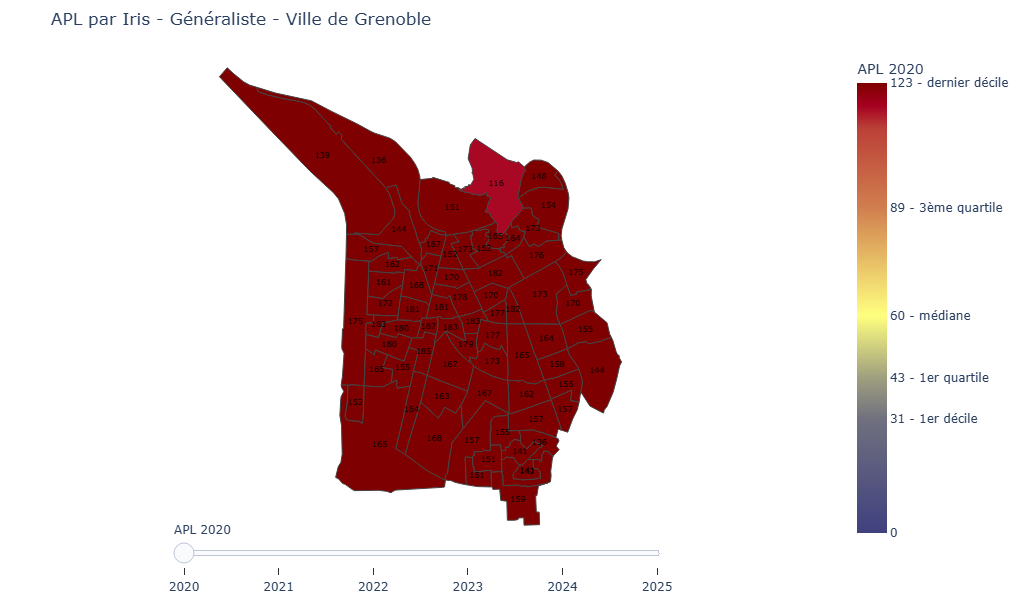

In [244]:
show_label=len(gdf) < 200
fig = go.Figure()
l=[]
l2=[]
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()
for year in years:
    gdf_year=gdf_merged[gdf_merged["year"]==year]
    l.append(
        go.Choropleth(
            visible=False,
            geojson=geojson,
            locations=gdf_year["fid"],
            z=gdf_year["apl_clip"],
            zmin=0,
            zmax=q90s[year-years[0]], #qmax,
            text=gdf_year.apply(
                lambda row: f"Commune: {row["nom_commune"]}<br>Iris: {row["code_iris"]}<br>Nom Iris: {row['nom_iris']}<br>APL 20{year}: {row['apl']:.1f}<br>Médiane APL: {(row["apl"]-q50s[year-years[0]])*100/(q50s[year-years[0]]+0.001):+.0f}% ({q50s[year-years[0]]:.1f})<br>Nb ETP: {row['nb']:.1f}<br>Population: {row['pop']:.0f}<br>Population ajustée: {row['pop_ajustee']:.0f}",
                axis=1
            ),
            hoverinfo="text",
            showscale=True,
            colorbar={"title": f"APL 20{year}",
                      "tickvals": [0, q10s[year-years[0]], q25s[year-years[0]], q50s[year-years[0]], q75s[year-years[0]], q90s[year-years[0]]],
                      "ticktext": ['0', f'{q10s[year-years[0]]:.0f} - 1er décile', f'{q25s[year-years[0]]:.0f} - 1er quartile', f'{q50s[year-years[0]]:.0f} - médiane', f'{q75s[year-years[0]]:.0f} - 3ème quartile', f'{q90s[year-years[0]]:.0f} - dernier décile'],
                     },
            colorscale=[[0.0, "rgb(64,64,127)"],
                        [q10s[year-years[0]]*1.0/q90s[year-years[0]], "rgb(112,112,127)"],
                        [q25s[year-years[0]]*1.0/q90s[year-years[0]], "rgb(159,159,127)"],
                        [q50s[year-years[0]]*1.0/q90s[year-years[0]], "rgb(255,255,127)"],
                        [q75s[year-years[0]]*1.0/q90s[year-years[0]], "rgb(209,127,79)"],
                        [0.90, "rgb(187,64,55)"],
                        [0.95, "rgb(165,0,32)"],
                        [1.0, "rgb(127,0,0)"]
                       ]
        ))
    if show_label:
        l2.append(
            go.Scattergeo(
                lon=gdf_year["lon"],
                lat=gdf_year["lat"],
                text=gdf_year["pretty"].astype(str),
                mode="text",
                textfont=dict(color="black", size=8),
                hoverinfo="skip",
                showlegend=False,
                visible=False,
                marker=dict(
                        color='#99ff99',
                        size=8,
                        line=dict(
                            color='#006600',
                            width=2
                        )
                    ),
            ))
fig = go.Figure(data=l+l2)   
fig.data[0].visible = True
if show_label:
    fig.data[len(l)].visible = True
steps = []
i=0
for year in years:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
             ],
        label=f"20{year}",
    )
    step["args"][0]["visible"][i] = True
    if show_label:
        step["args"][0]["visible"][i+len(l)] = True
    steps.append(step)
    i+=1

sliders = [dict(
    active=0,
    currentvalue={"prefix": "APL ", "visible":True},
    steps=steps,
    transition={'duration': 300, 'easing': 'cubic-in-out'},
    pad=dict(l=0, r=0, t=0, b=10),
    len=0.6,
    x=0.2,
    y=0.05,
)]

fig.update_layout(
    sliders=sliders,
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        # center_lon=center_lon,
        # center_lat=center_lat,
        # lonaxis_range=(center_lon-0.1, center_lon+0.1),
        # lataxis_range=(center_lat-0.1, center_lat+0.1),
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False,
    ),
    title=f"APL par Iris - {spe_df.loc[specialite]["label_long"]} - {"Ville de" if len(code_commune) != 3 else "Département"} {commune_nom if len(code_commune) != 3 else code_commune[:-1]}",
    # height=1000,
    # width=1200,
    height=600,
    # width=2000,  
    autosize=False,
    margin=dict(l=10, r=0, t=50, b=10),
)

fig.show()

In [231]:
gdf_merged["apl"].describe().apply("{0:.0f}".format)

count    4368
mean       66
std        52
min         0
25%        31
50%        57
75%        95
max       553
Name: apl, dtype: object

In [236]:
fig.update_layout(
    height=None,
    width=None, 
    autosize=True,
    # margin=dict(l=10, r=0, t=50, b=50)
)
pio.write_html(fig, file=f"out/apl_slider_{code_commune.replace("%","")}_{source}_{time}_{time_type}_{spe_df.loc[specialite].iloc[0]}.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})